# Mode choice models: v3 (groceries)

Reminder about parameter coding: 
- drone choice=1
- ground choice=0

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


transformed_data_filepath = './choice-model-data-long.csv'

In [2]:
choices_df = pd.read_csv(transformed_data_filepath)
choices_df.head()

,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,male,...,g_cost,d_cost,g_time,d_time,d_privacy,g_free,d_free,d_time - g_time,d_cost - g_cost,ID
0,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc0_gt1_dc0_dt0_dp0_1.1,1,2,0,1,0,0,0,1,...,0,0,20,15,0,1,1,-5,0,0
1,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc2_gt1_dc0_dt1_dp0_1.1,1,2,2,1,0,1,0,1,...,3,0,20,20,0,0,1,0,-3,0
2,R_3dNdOyEHwO3X5Tg,CHOICE_v0_gc0_gt3_dc2_dt1_dp0_1.1,0,0,0,3,2,1,0,1,...,0,3,45,20,0,1,0,-25,3,0
3,R_3dNdOyEHwO3X5Tg,CHOICE_v1_gc3_gt0_dc0_dt2_dp0_1.1,1,1,3,0,0,2,0,1,...,10,0,30,360,0,0,1,330,-10,0
4,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc3_gt3_dc0_dt3_dp0_1.1,1,2,3,3,0,3,0,1,...,5,0,45,45,0,0,1,0,-5,0


In [3]:
import sys  
sys.path.insert(0, '../survey-questions')

from attributes import (
    VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS,
)

color_ground = 'blue'
color_drone = 'red'

def plot_points_tradeoff_by_size(df, vendor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        df_p_agg = df_p[df_p['choice']==0].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count().rename('ground').to_frame()
        df_p_agg['drone'] = df_p_agg.index.map(df_p[df_p['choice']==1].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count())
        df_p_agg = df_p_agg.reset_index()
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['ground'],
            color=color_ground, alpha=0.5, label='choice: ground vehicle',
            marker='o',
        )
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['drone'],
            color=color_drone, alpha=0.5, label='choice: drone',
            marker='o',
        )   
        ax.set_xlabel('drone wait time - ground vehicle wait time (mins)')
        ax.set_ylabel('drone cost - ground vehicle cost (\$)')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
        ax.legend()
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost and time' % vendor)
    _ = fig.suptitle(title)

## Focus on v3 : groceries

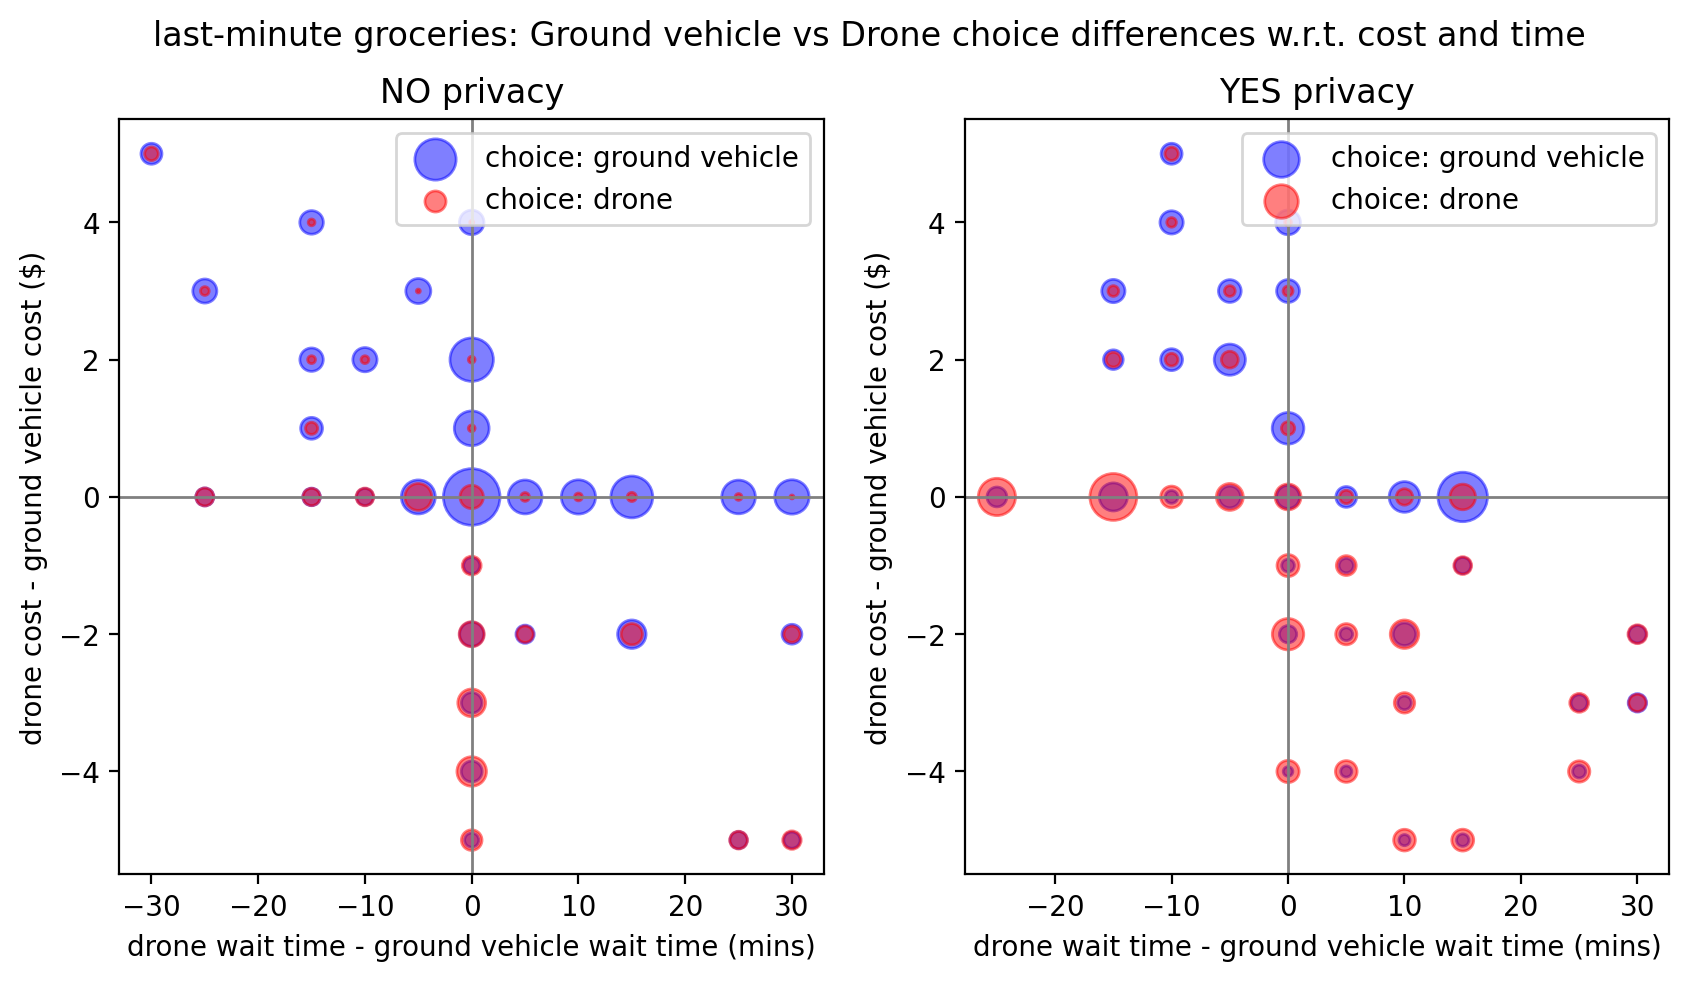

In [4]:
v=3
vdf = choices_df[choices_df['v']==v]
plot_points_tradeoff_by_size(vdf, VENDOR_TYPES[v][0])

## Dummy models



In [5]:
from pymer4.models import Lmer

In [6]:
usecols = [
    'choice',
    'd_time - g_time',
    'd_cost - g_cost',
    'd_privacy',
    'ResponseId'
]
v_choices_df = vdf[usecols]
# make d_time - g_time, d_cost - g_cost strings that can go in formula
formula = 'choice ~ d_time_minus_g_time + d_cost_minus_g_cost + d_privacy + (1|ResponseId)'
m = Lmer(formula, data=v_choices_df.rename(columns={
        'd_time - g_time':'d_time_minus_g_time',
        'd_cost - g_cost':'d_cost_minus_g_cost',
    }), family='binomial')
print(m.fit())

Formula: choice~d_time_minus_g_time+d_cost_minus_g_cost+d_privacy+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 8019	 Groups: {'ResponseId': 2577.0}

Log-likelihood: -3856.754 	 AIC: 7723.509

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  3.223  1.795

No random effect correlations specified

Fixed effects:

                     Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)            -1.969  -2.126   -1.813  0.080  0.140      0.119   
d_time_minus_g_time    -0.094  -0.102   -0.086  0.004  0.910      0.903   
d_cost_minus_g_cost    -0.892  -0.950   -0.834  0.030  0.410      0.387   
d_privacy               1.818   1.650    1.986  0.086  6.161      5.207   

                     OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  \
(Intercept)               0.163  0.122        0.107         0.140 -24.695   
d_time_minus_g_time       0.918  0.477        0.475         0.478 -23.570   
d_cost_minus_g

## Biogeme

Documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf


### Initial simple experiments

#### Generic vs alternative specific attributes.
We want to use alternative specific attributes, but start with generic.


#### Random coefficients
We want to model random effects/taste variation with a random parameter logit model. However, we start without this.


#### Iterative modeling process:

Start simplest, add complexity and use statistical tests to determine whether changes to the model add significant explanatory power.

Tests used:
- (baseline) verify parameters have expended signs
- (simplest) t-test: use t-test values and p-values to evaluate whether a parameter is statistically significant
- adjusted likelihood ratio index (rho bar squared) $\bar{\rho^2}$: evaluate whether adding a variable had a positive impact on this metric
- use likelihood ratio test

Modeling steps:

- generic model without free parameter
- add free paramter and test whether it adds statistically siginicant explanatory power
- test alternatve specific time parameter
- test alternative specific cost parameter
- -- not for now: test impact of random coefficients
    - this is not done in related work by Haan et al (2021); complicates estimation of VOT?
- test addition of consumer behavior and interactions with privacy parameter:
    - dummy variables:
        - online shopping more than 1x/week
        - take-out food delivery more than 1x/week
- test addition of socioeconomic variables and interactions with privacy parameter:
    - gender
    - age: dummy variable for older; dummy variable for younger
    - residential type: dummy variables:
        - private home, apartment
    - residential area: dummy:
        - urban, suburban, rural


#### Test with $\bar{\rho^2}$

Ben Akiva & Lerman (1985):

For the same estimation data set, the $\rho^2$ of a model always increases or at least stays the same whenever new variables are added to the model, a limitation it shares with regression statistic $R^2$. For this reason we also use the adjusted likelihood ratio index (rho bar squared):

$$
\bar{\rho^2} = 1 - \frac{L(\tilde{\beta}) - K }{L(0)}
$$
where K denotes the number of unknown parameters in the model.

#### Test with likelihood ratio test: generic vs alternative-specific attributes

Specify models with both generic and alternative-specific attributes.

Then use the likelihood ratio test (pages 28 and 164-167 in Ben Akiva & Lerman (1985)) to test which model specification should be used.

Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e. for cost and time:

$H_0$ : $\beta_{g\_cost} = \beta_{d\_cost}$ & $\beta_{g\_time} = \beta_{d\_time}$

The test statistic for the null hypothesis is 

$-2(L_R - L_U)$

which is asymtotically distributed as $X^2$ with $df = K_U - K_R$ degrees of freedom, where $K_U$, $K_R$ are the number of estimated parameters in the unrestricted and restricted models.

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom.

In [7]:
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
import biogeme.messaging as msg
from biogeme.expressions import (
    Beta,
    DefineVariable,
    bioDraws,
    PanelLikelihoodTrajectory,
    MonteCarlo,
    log,
)

In [8]:
model_choice_cols = [
    'ID',         # respondent ID - to model agent level effect
    
    'choice',     # 0=ground vehicle; 1=drone
    'g_cost',     # ground vehicle delivery cost
    'd_cost',     # drone delivery cost
    'g_free',
    'd_free',
    'g_time',     # ground vehicle delivery wait time
    'd_time',     # drone delivery wait time
    'd_privacy',  # 0=NO PRIVACY; 1=YES PRIVACY (for drone delivery)
    
    # dummy coded (0/1)
    'male',       # 1=male; 0=otherwise
    'age_young', 'age_old',
    'income_lower', 'income_med', 'income_higher',
    'residence_house', 'residence_apartment',
    'urban', 'suburban', 'rural',
    
    'freq_ecommerce',
    'freq_takeout_food',
    
]

In [9]:
def get_vendor_panel_database(v, name=None):
    """Returns new fresh database each time."""
    db_name = name if name else 'v%s'%v
    df = choices_df[choices_df['v']==v][model_choice_cols]
    database = db.Database(db_name, df)
    database.panel('ID')
    return database

In [10]:
database = get_vendor_panel_database(v)
database.data.head()

,ID,choice,g_cost,d_cost,g_free,d_free,g_time,d_time,d_privacy,male,...,income_med,income_higher,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food,_biogroups
0,0,0,5,5,0,0,30,45,1,1,...,0,1,0,1,1,0,0,0,1,1
1,0,1,3,1,0,0,15,45,0,1,...,0,1,0,1,1,0,0,0,1,1
2,0,0,3,3,0,0,15,20,0,1,...,0,1,0,1,1,0,0,0,1,1
3,2,1,5,3,0,0,15,20,1,0,...,0,0,1,0,0,1,0,0,0,2
4,2,0,1,5,0,0,45,30,0,0,...,0,0,1,0,0,1,0,0,0,2


In [11]:
globals().update(database.variables)
# print(database.variables)
# The Pandas data structure is available as database.data. Use all the
# Pandas functions to invesigate the database
database.data.describe()

,ID,choice,g_cost,d_cost,g_free,d_free,g_time,d_time,d_privacy,male,...,income_med,income_higher,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food,_biogroups
count,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000,...,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000,8019.000000
mean,1893.528245,0.374610,2.404913,2.174585,0.231700,0.248535,26.676643,28.423744,0.497942,0.468388,...,0.384212,0.230453,0.719790,0.255892,0.278339,0.548447,0.169473,0.254396,0.078938,1292.448934
std,1071.466257,0.484052,1.939669,1.884200,0.421944,0.432190,10.993504,11.277117,0.500027,0.499031,...,0.486439,0.421149,0.449129,0.436389,0.448209,0.497678,0.375192,0.435548,0.269658,745.122299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,15.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,967.000000,0.000000,1.000000,1.000000,0.000000,0.000000,20.000000,20.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,648.000000
50%,1912.000000,0.000000,3.000000,1.000000,0.000000,0.000000,20.000000,30.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1292.000000
75%,2814.000000,1.000000,5.000000,3.000000,0.000000,0.000000,30.000000,45.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1933.000000
max,3714.000000,1.000000,5.000000,5.000000,1.000000,1.000000,45.000000,45.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2577.000000


In [12]:
# https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# results.data.sampleSize: the sample size N.
# results.data.numberOfObservations: the number of rows in the data file. If the data is not panel, it is the same as the sample size.
# results.data.nparam: the number K of estimated parameters.
# results.data.logLike: the value L∗ of the log likelihood at the final value of the parameters.

# order how parameters are printed in this way; 
# accounting for when parameters are alternative specific or not, or included or not
param_order = [
    'ASC_G', 'ASC_D', 'ASC_G_MEAN', 'ASC_G_S', 'ASC_D_MEAN', 'ASC_D_S', 
    'B_TIME', 'B_G_TIME','B_D_TIME',
    'B_COST', 'B_G_COST', 'B_D_COST',
    'B_FREE',
    'B_DPRIVACY',
     # consumer attributes
    'B_FREQ_ECOMMERCE', 'B_FREQ_ECOMMERCE_PRIVACY', 
    'B_FREQ_TAKEOUT_FOOD', 'B_FREQ_TAKEOUT_FOOD_PRIVACY',
    # gender
    'B_MALE', 'B_MALE_PRIVACY',
    # age
    'B_AGE_YOUNG', 'B_AGE_YOUNG_PRIVACY',
    'B_AGE_OLD', 'B_AGE_OLD_PRIVACY',
    # income
    'B_INCOME_LOWER', 'B_INCOME_LOWER_PRIVACY',
    'B_INCOME_MED', 'B_INCOME_MED_PRIVACY',
    'B_INCOME_HIGHER', 'B_INCOME_HIGHER_PRIVACY',
    # residence
    'B_RESIDENCE_APARTMENT', 'B_RESIDENCE_APARTMENT_PRIVACY',
    'B_RESIDENCE_HOUSE', 'B_RESIDENCE_HOUSE_PRIVACY', 
    'B_RURAL', 'B_RURAL_PRIVACY', 
    'B_SUBURBAN', 'B_SUBURBAN_PRIVACY', 
    'B_URBAN', 'B_URBAN_PRIVACY',
]

def print_biogeme_results(results, display_pvalues=True, print_params=None):
    print('Model: %s' % results.data.modelName)
    print('\n---- Coefficients ----')
    params_df = results.getEstimatedParameters()
    params_df[''] = params_df['Rob. p-value'].apply(lambda p: '**' if p<0.01 else ('*' if p<0.05 else ''))
    # make a column that consolidates the p-value * and estimated Value
    params_df['Est.'] = params_df.apply(lambda row: '%0.3f%s' % (row['Value'], row['']), axis=1)
    params_df = params_df[
        ['Est.', 'Rob. Std err'] + (['Rob. p-value'] if display_pvalues else [])
    ].round(3)
    # get rid of trailing zeros from rounding
    params_df['Rob. Std err'] = params_df['Rob. Std err'].apply(lambda se: '%0.3f'%se)
    params_df = params_df.reindex([p for p in param_order if p in params_df.index])
    if print_params is not None:
        params_df = params_df.reindex(print_params).fillna('')
    display(params_df)
    print('\n---- Model statistics ----\n')
    stats = [
        'Sample size','Observations',
        'Number of estimated parameters',
        'Number of draws',
        'Init log likelihood','Final log likelihood',
        'Rho-square-bar for the init. model',
        'Akaike Information Criterion','Bayesian Information Criterion'
    ]
    model_stats = results.getGeneralStatistics()
    model_stats_df = pd.DataFrame({k: [v] for k, (v, _) in model_stats.items()})[
        [c for c in stats if c in model_stats.keys()]
    ].transpose()[[0]].round(3).rename(columns={0:'Value'})
    display(model_stats_df)
    return params_df, model_stats_df

### Simplest generic model

In [13]:
# without the random utility model we estimate models without using PanelLikelihoodTrajectory
# This is based on instruction from Professor Bierlaire (Biogeme author)
# see https://groups.google.com/g/biogeme/c/1CDNIpQoGPw

In [14]:
"""
Generic logit model
(free is not an attribute)

V_groundvehicle = ASC_g + B_cost * g_cost + B_time * g_time
V_drone =  B_cost * d_cost + B_time * d_time + B_dprivacy * d_privacy
(drone used as reference for ASC's)
"""
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G = Beta('ASC_G', 0, None, None, 0)
ASC_D = Beta('ASC_D', 0, None, None, 1) # 1: this will not change and will make this the reference for ASC's
B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_TIME*g_time
VD = ASC_D + B_COST*d_cost + B_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)
# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'v%s_generic_logit'%v
# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(av)
# Estimate the parameters
generic_logit_results = biogeme.estimate()
params_df, model_stats_df = print_biogeme_results(generic_logit_results)

Model: v3_generic_logit

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_G,1.288**,0.073,0.0
B_TIME,-0.066**,0.005,0.0
B_COST,-0.599**,0.031,0.0
B_DPRIVACY,1.162**,0.096,0.0



---- Model statistics ----



,Value
Sample size,2577.000
Observations,8019.000
Number of estimated parameters,4.000
Init log likelihood,-1786.240
Final log likelihood,-1339.781
Rho-square-bar for the init. model,0.248
Akaike Information Criterion,2687.562
Bayesian Information Criterion,2710.979


In [15]:
# estimated value of time:
# B_TIME/B_COST ($1/1 minute)
betas = generic_logit_results.getBetaValues()
vot = betas['B_TIME']/betas['B_COST']
print('VOT: willing ot pay $%0.2f to save 1 minute of time' % vot)

VOT: willing ot pay $0.11 to save 1 minute of time


### Alternative specific variance

We have panel data and reason to assume that the preference for drone/ground delivery is highly variable among individuals and should capture that agent level effect. We do this by specifying an alternative specific variance model.

Here the parameters for time, cost, and the ASC's are randomly
distributed with a normal distribution.

For the ASCs:
The normalization is not arbitrary. Only the minimum variance alternative should be normalized to 0. Therefore, proper estimation first requires the unidentified model be estimated (with all 2 variances in this case). Then the model should be re-estimated with the smallest variance from the unidentified model normalized to 0.

We therefore do this in 2 stages below.

1. Estimate all variances
2. Fix minimum variance alternative to 0. Also use the parameter values from (1) as starting values for faster estimation.

For 1,2, see Biogeme's files for example: 12panel, [13panel (changed)](https://github.com/michelbierlaire/biogeme/blob/ce360416aedf145b8b93024aef173c6701ac4159/examples/swissmetro/13panelNormalized.ipynb).

In [16]:
"""
Alternative specific variance generic logit model
(free is not an attribute)

V_groundvehicle = ASC_g + B_cost * g_cost + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_time * d_time + B_dprivacy * d_privacy

The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

1. estimate all ASC variances to identify minimum variance alternative.

"""
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)
# Parameters to be estimated
# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # initially fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', 0, None, None, 0)
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_TIME*g_time
VD = ASC_D + B_COST*d_cost + B_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
# Conditional to the random parameters, the likelihood of one observation
obsprob = models.logit(V, av, choice)
# Conditional to the random parameters, the likelihood of all observations for
# one individual (the trajectory) is the product of the likelihood of
# each observation.
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
# We integrate over the random parameters using Monte-Carlo
logprob = log(MonteCarlo(condprobIndiv))

msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 100
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    seed=12,
    userNotes=(
        'Initial estimation of model with alternative specific variance. '
        'Rerun this model where the minimum variance ASC is fixed to 0.'
    )
)
biogeme.modelName = 'v%s_generic_logit_asc_variance_1'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(results)

100 draws
start time: 17:18:47
[17:18:47] < Warning >   Cannot read file __v3_generic_logit_asc_variance_1.iter. Statement is ignored.
end time: 17:19:20
Model: v3_generic_logit_asc_variance_1

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_G_S,0.236,0.498,0.635
ASC_D_MEAN,-1.986**,0.084,0.000
ASC_D_S,1.892**,0.108,0.000
B_TIME,-0.094**,0.004,0.000
B_COST,-0.893**,0.033,0.000
B_DPRIVACY,1.840**,0.091,0.000



---- Model statistics ----



,Value
Sample size,2577.000
Observations,8019.000
Number of estimated parameters,6.000
Number of draws,100.000
Init log likelihood,-5295.972
Final log likelihood,-3832.888
Rho-square-bar for the init. model,0.275
Akaike Information Criterion,7677.776
Bayesian Information Criterion,7712.902


The variance for ground vehicle is not statistically significant.

For convenience, we use the same specification here as for the other vendor types:

We estimate the models with the ground vehicle ASC normalized to 0.

For completeness, we continue with step 2.

In [17]:
"""
Alternative specific variance generic logit model
(free is not an attribute)

V_groundvehicle = B_cost * g_cost + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_time * d_time + B_dprivacy * d_privacy

The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

2. Fix minimum variance alternative to 0. 
Also use the parameter values from (1) as starting values for faster estimation.

"""
database = get_vendor_panel_database(v)
globals().update(database.variables)

# Parameters to be estimated
# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
# ASC_G_MEAN fixed as reference
ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_TIME*g_time
VD = ASC_D + B_COST*d_cost + B_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
# Conditional to the random parameters, the likelihood of one observation
obsprob = models.logit(V, av, choice)
# Conditional to the random parameters, the likelihood of all observations for
# one individual (the trajectory) is the product of the likelihood of
# each observation.
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
# We integrate over the random parameters using Monte-Carlo
logprob = log(MonteCarlo(condprobIndiv))

msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 100
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    seed=12,
    userNotes=(
        'Second estimation of model with alternative specific variance. '
    )
)
biogeme.modelName = 'v%s_generic_logit_asc_variance_2'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(results)

100 draws
start time: 17:19:22
[17:19:22] < Warning >   Cannot read file __v3_generic_logit_asc_variance_2.iter. Statement is ignored.
end time: 17:19:39
Model: v3_generic_logit_asc_variance_2

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-1.986**,0.084,0.0
ASC_D_S,1.906**,0.088,0.0
B_TIME,-0.094**,0.004,0.0
B_COST,-0.893**,0.033,0.0
B_DPRIVACY,1.840**,0.091,0.0



---- Model statistics ----



,Value
Sample size,2577.000
Observations,8019.000
Number of estimated parameters,5.000
Number of draws,100.000
Init log likelihood,-6014.379
Final log likelihood,-3833.044
Rho-square-bar for the init. model,0.362
Akaike Information Criterion,7676.087
Bayesian Information Criterion,7705.359


In [18]:
# estimated value of time:
# B_TIME/B_COST ($1/1 minute)
betas = results.getBetaValues()
vot = betas['B_TIME']/betas['B_COST']
print('VOT: willing ot pay $%0.2f to save 1 minute of time' % vot)

VOT: willing ot pay $0.11 to save 1 minute of time


#### Results

The VOT barely changed (good).

The $\bar{\rho^2}$ is improved over the model without the alternative specific variance -- indicating the alternative specific variance model is an improvement.


#### Adding a coefficient for free

In [19]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_time * d_time + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
# ASC_G_MEAN fixed as reference
ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free + B_TIME*g_time
VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 100
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    seed=12,
    userNotes=(
        'test free after alternative specific variance'
    )
)
biogeme.modelName = 'v%s_generic_asv_free'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(results)

100 draws
start time: 17:19:41
[17:19:41] < Warning >   Cannot read file __v3_generic_asv_free.iter. Statement is ignored.
end time: 17:20:03
Model: v3_generic_asv_free

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-1.968**,0.084,0.000
ASC_D_S,1.900**,0.088,0.000
B_TIME,-0.095**,0.004,0.000
B_COST,-0.847**,0.035,0.000
B_FREE,0.297**,0.100,0.003
B_DPRIVACY,1.821**,0.091,0.000



---- Model statistics ----



,Value
Sample size,2577.000
Observations,8019.000
Number of estimated parameters,6.000
Number of draws,100.000
Init log likelihood,-6014.379
Final log likelihood,-3828.422
Rho-square-bar for the init. model,0.362
Akaike Information Criterion,7668.844
Bayesian Information Criterion,7703.970


In [20]:
# estimated value of time:
# B_TIME/B_COST ($1/1 minute)
betas = results.getBetaValues()
vot = betas['B_TIME']/betas['B_COST']
print('VOT: willing ot pay $%0.2f to save 1 minute of time' % vot)
# what is the value of free? How much extra time would you wait?
# FREE/TIME
tradeoff = betas['B_FREE']/betas['B_TIME']
print('willing to trade %0.2f minutes of time for free?' % tradeoff)

VOT: willing ot pay $0.11 to save 1 minute of time
willing to trade -3.13 minutes of time for free?


#### Results

Overall, adding a coefficient to represent whether delivery is free seems to improve the model.

- free coefficient statistically significant
- improved value for $\bar{\rho^2}$
- VOT not changed (increased by $0.01) even though free is statistically significant


### Modeling with alternative-specific attributes

We use above model with generic time and cost coefficients as the restricted model.

We then test a (unrestricted model) specification with alternative specific cost coefficient.

In [21]:
# get previous model results (restricted model) for comparison
restricted_results = results

#### Test alternative specific time coefficient

Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e.

$H_0$ : $\beta_{g\_time} = \beta_{d\_time}$

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom. Here df=1

In [22]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_g_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_d_time * d_time + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
    
time coefficient is alternative specific

"""
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
# ASC_G_MEAN fixed as reference
ASC_D_MEAN = Beta('ASC_D_MEAN', 0, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', -2, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_G_TIME = Beta('B_G_TIME', 0, None, None, 0)
B_D_TIME = Beta('B_D_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free + B_G_TIME*g_time
VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_D_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

logger = msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 100
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    seed=12,
    userNotes=(
        'test alternative specific time coefficient with alternative specific variance + free'
    )
)
biogeme.modelName = 'v%s_as_time'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
unrestricted_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(unrestricted_results)

100 draws
start time: 17:20:05
[17:20:05] < Warning >   Cannot read file __v3_as_time.iter. Statement is ignored.
end time: 17:20:28
Model: v3_as_time

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-2.046**,0.155,0.000
ASC_D_S,-1.900**,0.088,0.000
B_G_TIME,-0.096**,0.005,0.000
B_D_TIME,-0.094**,0.005,0.000
B_COST,-0.849**,0.035,0.000
B_FREE,0.287**,0.101,0.005
B_DPRIVACY,1.833**,0.092,0.000



---- Model statistics ----



,Value
Sample size,2577.000
Observations,8019.000
Number of estimated parameters,7.000
Number of draws,100.000
Init log likelihood,-5350.582
Final log likelihood,-3828.260
Rho-square-bar for the init. model,0.283
Akaike Information Criterion,7670.521
Bayesian Information Criterion,7711.502


Perform the likelihood ratio test

In [23]:
K_R = restricted_results.data.nparam
K_U = unrestricted_results.data.nparam
df = K_U - K_R
print('df=%s'%df)

L_R = restricted_results.data.logLike
L_U = unrestricted_results.data.logLike
test_stat = -2*(L_R - L_U)
print('−2(L_R - L_U)=%0.4f' % test_stat)
print('X_2,0.05 = 3.84')
if test_stat > 3.84:
    print('can reject the null hypothesis')
else:
    print('cannot reject the null hypothesis')

df=1
−2(L_R - L_U)=0.3225
X_2,0.05 = 3.84
cannot reject the null hypothesis


#### Test alternative specific cost coefficient


Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e.

$H_0$ : $\beta_{g\_cost} = \beta_{d\_cost}$

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom. Here df=1

In [24]:
"""
V_groundvehicle = B_g_cost * g_cost + B_free * g_free + B_time * g_time
V_drone =  ASC_d + B_d_cost * d_cost + B_free * d_free + B_time * d_time + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
    
cost coefficient is alternative specific

"""
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
# ASC_G_MEAN fixed as reference

ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_G_COST = Beta('B_G_COST', 0, None, None, 0)
B_D_COST = Beta('B_D_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)


# Definition of the utility functions
VG = B_G_COST*g_cost + B_FREE*g_free + B_TIME*g_time
VD = ASC_D + B_D_COST*d_cost + B_FREE*d_free + B_TIME*d_time + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 100
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    seed=12, # use a consistent seed for consistent results
    userNotes=(
        'test alternative specific cost coefficient with alternative specific variance + free'
    )
)
biogeme.modelName = 'v%s_as_cost'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
unrestricted_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(unrestricted_results)

100 draws
start time: 17:20:30
[17:20:30] < Warning >   Cannot read file __v3_as_cost.iter. Statement is ignored.
end time: 17:20:56
Model: v3_as_cost

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-1.930**,0.094,0.000
ASC_D_S,1.901**,0.088,0.000
B_TIME,-0.095**,0.004,0.000
B_G_COST,-0.839**,0.036,0.000
B_D_COST,-0.858**,0.038,0.000
B_FREE,0.293**,0.100,0.003
B_DPRIVACY,1.825**,0.091,0.000



---- Model statistics ----



,Value
Sample size,2577.000
Observations,8019.000
Number of estimated parameters,7.000
Number of draws,100.000
Init log likelihood,-6014.379
Final log likelihood,-3828.119
Rho-square-bar for the init. model,0.362
Akaike Information Criterion,7670.238
Bayesian Information Criterion,7711.219


Perform the likelihood ratio test

In [25]:
K_R = restricted_results.data.nparam
K_U = unrestricted_results.data.nparam
df = K_U - K_R
print('df=%s'%df)

L_R = restricted_results.data.logLike
L_U = unrestricted_results.data.logLike
test_stat = -2*(L_R - L_U)
print('−2(L_R - L_U)=%0.4f' % test_stat)
print('X_1,0.05 = 3.84')
if test_stat > 3.84:
    print('can reject the null hypothesis')
else:
    print('cannot reject the null hypothesis')

df=1
−2(L_R - L_U)=0.6055
X_1,0.05 = 3.84
cannot reject the null hypothesis


#### Results overview

This is different from other vendors:
results do not indicate either time or cost should be alternative specific.

We continue with generic parameters for both time and cost.

### Consumer behavior attributes and interactions with privacy parameter

We add in the following parameters. Positively estimated coefficients will indicate a positive relationship between these parameters and drone preference.

- freq_ecommerce: online shopping more than 1x/week (0/1)
- freq_takeout_food: take-out food delivery more than 1x/week

In [26]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_time * d_time + B_dprivacy * d_privacy
    + B_freq_ecommerce * freq_ecommerce 
    + B_freq_ecommerce_privacy * freq_ecommerce * d_privacy
    + B_freq_takeout_food * freq_takeout_food 
    + B_freq_takeout_food_privacy * freq_takeout_food * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
"""

database = get_vendor_panel_database(v)
globals().update(database.variables)

# Parameters to be estimated
# ASC_G_MEAN fixed as reference
ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_G_COST = Beta('B_COST', 0, None, None, 0)
B_D_COST = Beta('B_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0)
B_FREQ_ECOMMERCE_PRIVACY = Beta('B_FREQ_ECOMMERCE_PRIVACY', 0, None, None, 0)
B_FREQ_TAKEOUT_FOOD = Beta('B_FREQ_TAKEOUT_FOOD', 0, None, None, 0)
B_FREQ_TAKEOUT_FOOD_PRIVACY = Beta('B_FREQ_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free + B_TIME*g_time

VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_TIME*d_time \
    + B_DPRIVACY*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce \
    + B_FREQ_ECOMMERCE_PRIVACY*freq_ecommerce*d_privacy \
    + B_FREQ_TAKEOUT_FOOD*freq_takeout_food \
    + B_FREQ_TAKEOUT_FOOD_PRIVACY*freq_takeout_food*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 100
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    seed=12,
    userNotes=(
        'test with consumer behavior variables'
    )
)
biogeme.modelName = 'v%s_freq_consumer'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
cons_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(cons_results)

100 draws
start time: 17:20:58
[17:20:58] < Warning >   Cannot read file __v3_freq_consumer.iter. Statement is ignored.
end time: 17:21:36
Model: v3_freq_consumer

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-2.025**,0.095,0.000
ASC_D_S,1.899**,0.088,0.000
B_TIME,-0.095**,0.004,0.000
B_COST,-0.846**,0.035,0.000
B_FREE,0.301**,0.100,0.003
B_DPRIVACY,1.859**,0.104,0.000
B_FREQ_ECOMMERCE,0.159,0.154,0.302
B_FREQ_ECOMMERCE_PRIVACY,-0.020,0.191,0.918
B_FREQ_TAKEOUT_FOOD,0.197,0.247,0.424
B_FREQ_TAKEOUT_FOOD_PRIVACY,-0.397,0.306,0.195



---- Model statistics ----



,Value
Sample size,2577.000
Observations,8019.000
Number of estimated parameters,10.000
Number of draws,100.000
Init log likelihood,-6014.379
Final log likelihood,-3826.561
Rho-square-bar for the init. model,0.362
Akaike Information Criterion,7673.122
Bayesian Information Criterion,7731.666


#### Results overview

Consumer behavior parameters not statistically significant

### Demographic variables and interactions with privacy parameter

We add in the following parameters. Positively estimated coefficients will indicate a positive relationship between these parameters and drone preference.

- gender: male/other (1/0)
- age: age_young, age_old (0/1)
- income: lower, medium, higher (0/1)
    - only include lower, higher
- residential type: residence_house (0/1)
- residential area: urban, suburban, rural (0/1)
    only include 2: urban, suburban

In [27]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_time * d_time 
    + B_dprivacy * d_privacy
    + B_freq_ecommerce * freq_ecommerce 
    + B_freq_ecommerce_privacy * freq_ecommerce * d_privacy
    + B_male * male + B_gender_privacy * gender * d_privacy
    + B_age_young * age_young + B_age_old * age_old
    + B_income_lower * income_lower + B_income_higher * income_higher
    + B_residence_house * residence_house
    + B_urban * urban 
    + B_suburban * suburban 
    + [demographics] * privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
"""
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
# ASC_G_MEAN fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -1.6, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# socioeconomic variables
B_MALE = Beta('B_MALE', 0, None, None, 0)
B_MALE_PRIVACY = Beta('B_MALE_PRIVACY', 0, None, None, 0)

B_AGE_YOUNG = Beta('B_AGE_YOUNG', 0, None, None, 0)
B_AGE_OLD = Beta('B_AGE_OLD', 0, None, None, 0)
B_AGE_YOUNG_PRIVACY = Beta('B_AGE_YOUNG_PRIVACY', 0, None, None, 0)
B_AGE_OLD_PRIVACY = Beta('B_AGE_OLD_PRIVACY', 0, None, None, 0)

B_INCOME_LOWER = Beta('B_INCOME_LOWER', 0, None, None, 0)
B_INCOME_HIGHER = Beta('B_INCOME_HIGHER', 0, None, None, 0)
B_INCOME_LOWER_PRIVACY = Beta('B_INCOME_LOWER_PRIVACY', 0, None, None, 0)
B_INCOME_HIGHER_PRIVACY = Beta('B_INCOME_HIGHER_PRIVACY', 0, None, None, 0)

B_RESIDENCE_HOUSE = Beta('B_RESIDENCE_HOUSE', 0, None, None, 0)
B_RESIDENCE_HOUSE_PRIVACY = Beta('B_RESIDENCE_HOUSE_PRIVACY', 0, None, None, 0)

B_URBAN = Beta('B_URBAN', 0, None, None, 0)
B_SUBURBAN = Beta('B_SUBURBAN', 0, None, None, 0)
B_URBAN_PRIVACY = Beta('B_URBAN_PRIVACY', 0, None, None, 0)
B_SUBURBAN_PRIVACY = Beta('B_SUBURBAN_PRIVACY', 0, None, None, 0)


# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free + B_TIME*g_time

VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_TIME*d_time \
    + B_DPRIVACY*d_privacy \
    + B_MALE*male + B_MALE_PRIVACY*male*d_privacy \
    + B_AGE_YOUNG*age_young + B_AGE_OLD*age_old \
    + B_AGE_YOUNG_PRIVACY*age_young*d_privacy + B_AGE_OLD_PRIVACY*age_old*d_privacy \
    + B_INCOME_LOWER*income_lower + B_INCOME_LOWER_PRIVACY*income_lower*d_privacy \
    + B_INCOME_HIGHER*income_higher + B_INCOME_HIGHER_PRIVACY*income_higher*d_privacy \
    + B_RESIDENCE_HOUSE*residence_house + B_RESIDENCE_HOUSE_PRIVACY*residence_house*d_privacy \
    + B_URBAN*urban + B_URBAN_PRIVACY*urban*d_privacy \
    + B_SUBURBAN*suburban + B_SUBURBAN_PRIVACY*suburban*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 100
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    seed=12,
    userNotes=(
        'test with socioeconomic variables'
    )
)
biogeme.modelName = 'v%s_demographics'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
demo_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(demo_results)

100 draws
start time: 17:21:37
[17:21:37] < Warning >   Cannot read file __v3_demographics.iter. Statement is ignored.
end time: 17:24:37
Model: v3_demographics

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-1.880**,0.267,0.000
ASC_D_S,1.853**,0.087,0.000
B_TIME,-0.095**,0.004,0.000
B_COST,-0.849**,0.035,0.000
B_FREE,0.286**,0.099,0.004
B_DPRIVACY,1.967**,0.324,0.000
B_MALE,0.618**,0.137,0.000
B_MALE_PRIVACY,-0.219,0.165,0.185
B_AGE_YOUNG,-0.069,0.146,0.635
B_AGE_YOUNG_PRIVACY,0.390*,0.178,0.029



---- Model statistics ----



,Value
Sample size,2577.000
Observations,8019.000
Number of estimated parameters,22.000
Number of draws,100.000
Init log likelihood,-5588.812
Final log likelihood,-3790.278
Rho-square-bar for the init. model,0.318
Akaike Information Criterion,7624.556
Bayesian Information Criterion,7753.353


#### Results overview

age:
- older ppl less likely to choose drone
- *young ppl value privacy more*

gender
- males prefer drone more than others
- males value privacy less than others

no significant coefficients for residential areas/types


### Estimating a final model

After reviewing the significant coefficients from the models estimated for each vendor type, we choose a model specification that uses consistent consumer group variables across the models. 

These variables are chosen to represent variables that were statistically significant in models for at least one vendor.


Frequent e-commerce use
- alone statistically significant in models for multiple vendors
- interaction effect x privacy not significant

Residential area
- urban statistically significant in multiple models
- interaction effect x privacy NOT significant in any model - not included

In [28]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_time * d_time 
    + B_dprivacy * d_privacy
    + B_freq_ecommerce * freq_ecommerce
    + B_male * male + B_male_privacy * male * d_privacy
    + B_age_young * age_young + B_age_old * age_old
    + B_urban * urban 
    + B_suburban * suburban
    + [age demographics] * privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""
database = get_vendor_panel_database(v)
globals().update(database.variables)

# Parameters to be estimated
# ASC_G_MEAN fixed as reference
ASC_D_MEAN = Beta('ASC_D_MEAN', -1.8, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1.8, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_G_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0)

# socioeconomic variables
B_MALE = Beta('B_MALE', 0, None, None, 0)
B_MALE_PRIVACY = Beta('B_MALE_PRIVACY', 0, None, None, 0)

B_AGE_YOUNG = Beta('B_AGE_YOUNG', 0, None, None, 0)
B_AGE_OLD = Beta('B_AGE_OLD', 0, None, None, 0)
B_AGE_YOUNG_PRIVACY = Beta('B_AGE_YOUNG_PRIVACY', 0, None, None, 0)
B_AGE_OLD_PRIVACY = Beta('B_AGE_OLD_PRIVACY', 0, None, None, 0)

B_URBAN = Beta('B_URBAN', 0, None, None, 0)
B_SUBURBAN = Beta('B_SUBURBAN', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free + B_TIME*g_time
VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_TIME*d_time \
    + B_DPRIVACY*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce \
    + B_MALE*male + B_MALE_PRIVACY*male*d_privacy \
    + B_AGE_YOUNG*age_young + B_AGE_OLD*age_old \
    + B_AGE_YOUNG_PRIVACY*age_young*d_privacy + B_AGE_OLD_PRIVACY*age_old*d_privacy \
    + B_URBAN*urban \
    + B_SUBURBAN*suburban

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 5000
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    seed=12, # use a consistent seed for consistent results
    userNotes=(
        'Final v3 model estimation'
    )
)
biogeme.modelName = 'v%s_final'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
final_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params, model_stats = print_biogeme_results(final_results)

5000 draws
start time: 11:29:27
[11:29:27] < Warning >   Cannot read file __v3_final.iter. Statement is ignored.
end time: 16:13:39
Model: v3_final

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-1.988**,0.177,0.000
ASC_D_S,1.865**,0.086,0.000
B_TIME,-0.095**,0.004,0.000
B_COST,-0.856**,0.035,0.000
B_FREE,0.285**,0.099,0.004
B_DPRIVACY,1.789**,0.154,0.000
B_FREQ_ECOMMERCE,0.229*,0.116,0.048
B_MALE,0.655**,0.138,0.000
B_MALE_PRIVACY,-0.216,0.166,0.194
B_AGE_YOUNG,0.003,0.146,0.984



---- Model statistics ----



,Value
Sample size,2577.000
Observations,8019.000
Number of estimated parameters,15.000
Number of draws,5000.000
Init log likelihood,-5436.619
Final log likelihood,-3790.575
Rho-square-bar for the init. model,0.300
Akaike Information Criterion,7611.151
Bayesian Information Criterion,7698.966


In [38]:
betas = final_results.getBetaValues()
# estimated value of time:
# B_TIME/B_COST
vot = betas['B_TIME']/betas['B_COST']
print('VOT ($): %0.2f' % vot)

print('how to evaluate value of privacy?')
vop = -1*betas['B_DPRIVACY']/betas['B_COST']
print('cost value for drone privacy ($): %0.2f' % vop)
vop = -1*betas['B_DPRIVACY']/betas['B_TIME']
print('time value for drone privacy (minutes): %0.2f' % vop)

VOT ($): 0.11
how to evaluate value of privacy?
cost value for drone privacy ($): 2.09
time value for drone privacy (minutes): 18.75


Get the results for exporting to a table

In [34]:
# for each exporting to table with all model results, print out a consistent list of 
# parameters. This includes rows of white space
print_params = [
    'ASC_G', 'ASC_D_MEAN', 'ASC_D_S', 
    '',
    'B_TIME', 'B_G_TIME','B_D_TIME',
    '',
    'B_COST', 'B_G_COST', 'B_D_COST',
    'B_FREE',
    'B_DPRIVACY',
     # consumer attributes
    'consumer attributes',
    'B_FREQ_ECOMMERCE',
    'gender',
    # gender
    'B_MALE', 'B_MALE_PRIVACY',
    # age
    'age',
    'B_AGE_YOUNG', 'B_AGE_YOUNG_PRIVACY',
    'B_AGE_OLD', 'B_AGE_OLD_PRIVACY',
    # residence
    'residential area',
    'B_SUBURBAN','B_URBAN',
]

params_df, model_stats_df = print_biogeme_results(final_results, 
                                                  display_pvalues=False, 
                                                  print_params=print_params)

Model: v3_final

---- Coefficients ----


,Est.,Rob. Std err
ASC_G,,
ASC_D_MEAN,-1.988**,0.177
ASC_D_S,1.865**,0.086
,,
B_TIME,-0.095**,0.004
B_G_TIME,,
B_D_TIME,,
,,
B_COST,-0.856**,0.035
B_G_COST,,



---- Model statistics ----



,Value
Sample size,2577.000
Observations,8019.000
Number of estimated parameters,15.000
Number of draws,5000.000
Init log likelihood,-5436.619
Final log likelihood,-3790.575
Rho-square-bar for the init. model,0.300
Akaike Information Criterion,7611.151
Bayesian Information Criterion,7698.966


In [35]:
display(params_df[['Est.', 'Rob. Std err']].style.hide_index())

Est.,Rob. Std err
,
-1.988**,0.177
1.865**,0.086
,
-0.095**,0.004
,
,
,
-0.856**,0.035
,


In [36]:
display(model_stats_df.style.hide_index())

Value
2577.000000
8019.000000
15.000000
5000.000000
-5436.619000
-3790.575000
0.300000
7611.151000
7698.966000
